# Simulation of the wireless communication system project in Signals and transforms

In [3]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import sounddevice as sd
import wcslib as wcs
from scipy.signal import sosfreqz

## Parameters

In [ ]:

channel_id = 17
Tb = 0.02
Ac = 1
fc = 4400
bs = 1 / Tb
wc = 27646    # rad/s
alpha = 2 * np.pi * 200
# Ar = |H(w)| * Ac
tr = 1
phi = -wc*tr

# Lab 2
K = 5
s_freq = fc * K
Ts = 1 / s_freq 
f_nyquist = s_freq/2 #11000 Hz

Ap = 2
As = 40
wp = [4350, 4450] # Bandwidth 100 Hz
ws = [4300, 4500]
wp_norm = [f*(2*np.pi) for f in wp]
ws_norm = [f*(2*np.pi) for f in ws]

wp_norm_d = np.array(wp) / f_nyquist
ws_norm_d = np.array(ws) / f_nyquist

#Lowpass filter parameters
Ap_lp = 0.8 #passband ripple in db
As_lp = 40 #stopband attenuation in db
Wp_lp = 60 #HZ passband edge
Ws_lp = 110 #Hz stopband edge
wp_lp_norm = Wp_lp*(2*np.pi)
ws_lp_norm = Ws_lp*(2*np.pi)

wp_lp_norm_d = Wp_lp/f_nyquist
ws_lp_norm_d = Ws_lp/f_nyquist


# Message to be transmitted
data = "Hello World!"

## Filter design

Bandpass filter order: 5.0
Lowpass filter order: 9.0


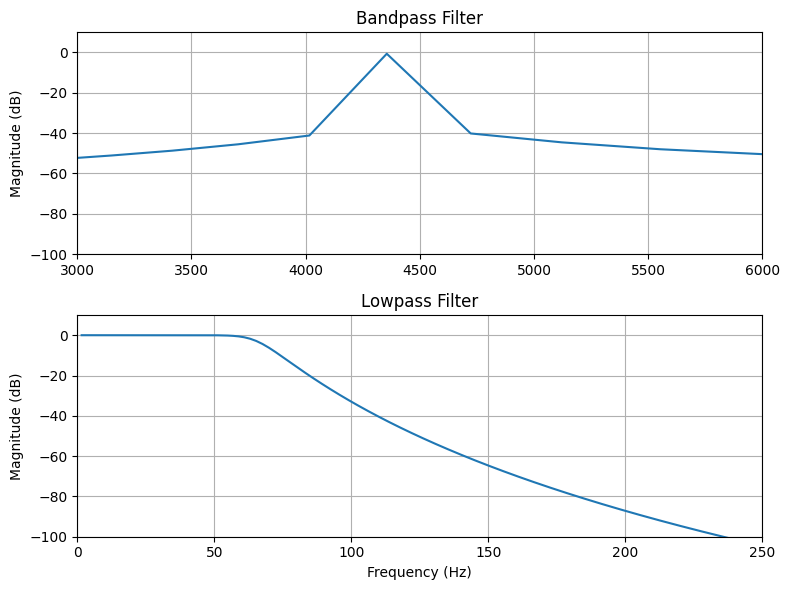

In [18]:
# TODO: Design the filters ANALOG

# Nb, w_c = signal.buttord(wp_norm, ws_norm, Ap, As, analog=True)
# Nb = np.abs(np.ceil(Nb))
# bb, ab = signal.butter(Nb, w_c, btype='bandpass', analog=True)
# wb, Hb = signal.freqs(bb, ab)
# print(f"Bandpass filter order: {Nb}")

Nb, w_c = signal.cheb2ord(wp_norm, ws_norm, Ap, As, analog=True)
Nb = np.abs(np.ceil(Nb))
bb, ab = signal.cheby2(Nb, As, w_c, btype='bandpass', analog=True)
wb, Hb = signal.freqs(bb, ab)
print(f"Bandpass filter order: {Nb}")

# #LP FILTER
N_lp, Wn_lp = signal.buttord(wp_lp_norm, ws_lp_norm, Ap_lp, As_lp, analog=True)
N_lp = np.abs(np.ceil(N_lp))
print(f"Lowpass filter order: {N_lp}")
b_lp, a_lp = signal.butter(N_lp,Wn_lp, btype='lowpass', analog=True)
w_bp, h_bp = signal.freqs(bb, ab)
f_bp = w_bp / (2*np.pi)  # convert from rad/s to Hz

# Lowpass filter coefficients: b_lp, a_lp
w_lp, h_lp = signal.freqs(b_lp, a_lp)
f_lp = w_lp / (2*np.pi)  # convert from rad/s to Hz

# Plot both filters
fig, ax = plt.subplots(2,1, figsize=(8,6))

# Bandpass
ax[0].plot(f_bp, 20*np.log10(np.abs(h_bp)))
ax[0].set_title("Bandpass Filter")
ax[0].set_ylabel("Magnitude (dB)")
ax[0].set_xlim(3000,6000)
ax[0].set_ylim(-100,10)
ax[0].grid(True)

# Lowpass
ax[1].plot(f_lp, 20*np.log10(np.abs(h_lp)))
ax[1].set_title("Lowpass Filter")
ax[1].set_xlabel("Frequency (Hz)")
ax[1].set_xlim(0,250)
ax[1].set_ylim(-100,10)

ax[1].set_ylabel("Magnitude (dB)")
ax[1].grid(True)

plt.tight_layout()
plt.show()


Bandpass filter order: 5.0
Lowpass filter order: 9.0


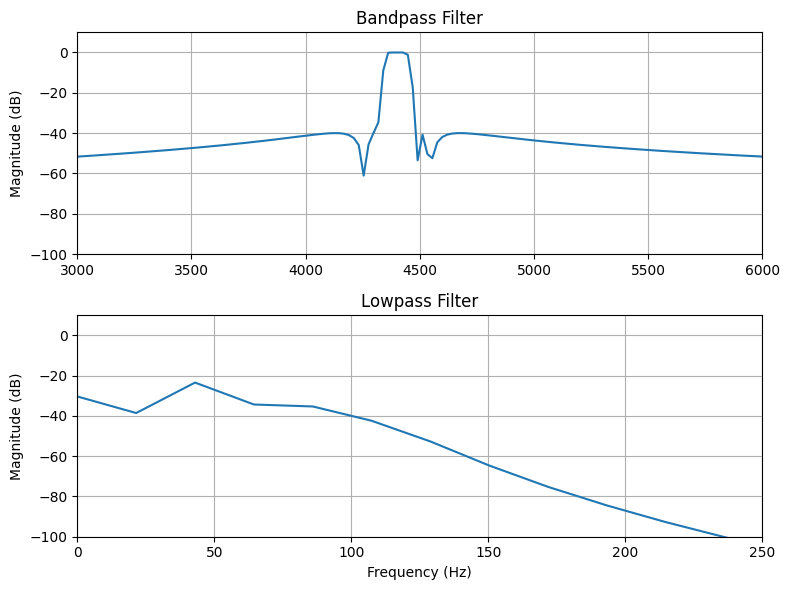

In [20]:

#DIGITAL FILTERS

Nb, w_c = signal.cheb2ord(wp_norm_d, ws_norm_d, Ap, As, analog=False)
Nb = np.abs(np.ceil(Nb))
bb, ab = signal.iirdesign(wp=wp_norm_d, ws=ws_norm_d, gpass=Ap, gstop=As, ftype='cheby2', output='ba')
wb, Hb = signal.freqz(bb, ab)
print(f"Bandpass filter order: {Nb}")

# #LP FILTER
N_lp, Wn_lp = signal.buttord(wp_lp_norm_d, ws_lp_norm_d, Ap_lp, As_lp, analog=False)
N_lp = np.abs(np.ceil(N_lp))
print(f"Lowpass filter order: {N_lp}")
b_lp, a_lp = signal.iirdesign(wp=wp_lp_norm_d, ws=ws_lp_norm_d, gpass=Ap_lp, gstop=As_lp, ftype='butter', output='ba')
w_bp, h_bp = signal.freqz(bb, ab)
f_bp = w_bp * f_nyquist /np.pi  # convert from rad/s to Hz

# Lowpass filter coefficients: b_lp, a_lp
w_lp, h_lp = signal.freqz(b_lp, a_lp)
f_lp = w_lp * f_nyquist /np.pi  # convert from rad/s to Hz

# Plot both filters
fig, ax = plt.subplots(2,1, figsize=(8,6))

# Bandpass
ax[0].plot(f_bp, 20*np.log10(np.abs(h_bp)))
ax[0].set_title("Bandpass Filter")
ax[0].set_ylabel("Magnitude (dB)")
ax[0].set_xlim(3000,6000)
ax[0].set_ylim(-100,10)
ax[0].grid(True)

# Lowpass
ax[1].plot(f_lp, 20*np.log10(np.abs(h_lp)))
ax[1].set_title("Lowpass Filter")
ax[1].set_xlabel("Frequency (Hz)")
ax[1].set_xlim(0,250)
ax[1].set_ylim(-100,10)

ax[1].set_ylabel("Magnitude (dB)")
ax[1].grid(True)

plt.tight_layout()
plt.show()



## Transmitter

In [21]:
# Convert string to bit sequence
bs = wcs.encode_string(data)
    
# Encode baseband signal
xb = wcs.encode_baseband_signal(bs, Tb, s_freq)

# TODO: Implement transmitter code here
t = np.arange(0, xb.shape[0]) * Ts 
xc = Ac * np.sin(wc * t)
xm = xb * xc
#xt = xm.copy()
xt_filt = signal.lfilter(bb,ab,xm)
# Ensure the signal is mono, then play through speakers
xt_play = np.stack((xt_filt, np.zeros(xt_filt.shape)), axis=1)
sd.play(xt_play, s_freq, blocking=True)

## Simulate transmission

In [14]:
yr = wcs.simulate_channel(xt_filt, s_freq, channel_id)

## Receiver

In [ ]:
# TODO: Put your receiver code (filtering, demodulation, etc.) here

T = xm.shape[0] * Ts
yr = sd.rec(int(T * s_freq), samplerate=s_freq, channels=1, blocking=True)
yr = yr[:, 0]

yr_filt = signal.lfilter(bb, ab, yr) #bandpass filter
t = np.arange(len(yr_filt)) / s_freq 

# # Calculate complex baseband signal
ybi = yr_filt * np.cos(wc*t)
print(ybi)
ybq = yr_filt * np.sin(wc*t)
print(ybq)
yb = ybi + 1j*ybq
yb = signal.lfilter(b_lp, a_lp, np.real(yb))
# Symbol decoding
br = wcs.decode_baseband_signal(yb, Tb, s_freq)

data_rx = wcs.decode_string(br)
print(f'Received: {data_rx} (no of bits: {len(br)}).')

[ 0.00000000e+00  0.00000000e+00 -0.00000000e+00 ...  6.24686954e-05
  1.41235880e-04 -1.04499623e-05]
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -4.83228609e-05
  9.62582827e-05  3.57915906e-05]
Received: ÛÀ (no of bits: 11).
